# Image features exercise
*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](https://compsci682-fa19.github.io/assignments2019/assignment1) on the course website.*

We have seen that we can achieve reasonable performance on an image classification task by training a linear classifier on the pixels of the input image. In this exercise we will show that we can improve our classification performance by training linear classifiers not on raw pixels but on features that are computed from the raw pixels.

All of your work for this exercise will be done in this notebook.

In [1]:

from __future__ import print_function
import random
import numpy as np
from cs682.data_utils import load_CIFAR10
import matplotlib.pyplot as plt


%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## Load data
Similar to previous exercises, we will load CIFAR-10 data from disk.

In [2]:
from cs682.features import color_histogram_hsv, hog_feature

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs682/datasets/cifar-10-batches-py'

    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # Subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    
    return X_train, y_train, X_val, y_val, X_test, y_test

# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()

## Extract Features
For each image we will compute a Histogram of Oriented
Gradients (HOG) as well as a color histogram using the hue channel in HSV
color space. We form our final feature vector for each image by concatenating
the HOG and color histogram feature vectors.

Roughly speaking, HOG should capture the texture of the image while ignoring
color information, and the color histogram represents the color of the input
image while ignoring texture. As a result, we expect that using both together
ought to work better than using either alone. Verifying this assumption would
be a good thing to try for your interests.

The `hog_feature` and `color_histogram_hsv` functions both operate on a single
image and return a feature vector for that image. The extract_features
function takes a set of images and a list of feature functions and evaluates
each feature function on each image, storing the results in a matrix where
each column is the concatenation of all feature vectors for a single image.

In [3]:
from cs682.features import *

num_color_bins = 10 # Number of bins in the color histogram
feature_fns = [hog_feature, lambda img: color_histogram_hsv(img, nbin=num_color_bins)]
X_train_feats = extract_features(X_train, feature_fns, verbose=True)
X_val_feats = extract_features(X_val, feature_fns)
X_test_feats = extract_features(X_test, feature_fns)

# Preprocessing: Subtract the mean feature
mean_feat = np.mean(X_train_feats, axis=0, keepdims=True)
X_train_feats -= mean_feat
X_val_feats -= mean_feat
X_test_feats -= mean_feat

# Preprocessing: Divide by standard deviation. This ensures that each feature
# has roughly the same scale.
std_feat = np.std(X_train_feats, axis=0, keepdims=True)
X_train_feats /= std_feat
X_val_feats /= std_feat
X_test_feats /= std_feat

# Preprocessing: Add a bias dimension
X_train_feats = np.hstack([X_train_feats, np.ones((X_train_feats.shape[0], 1))])
X_val_feats = np.hstack([X_val_feats, np.ones((X_val_feats.shape[0], 1))])
X_test_feats = np.hstack([X_test_feats, np.ones((X_test_feats.shape[0], 1))])

Done extracting features for 1000 / 49000 images
Done extracting features for 2000 / 49000 images
Done extracting features for 3000 / 49000 images
Done extracting features for 4000 / 49000 images
Done extracting features for 5000 / 49000 images
Done extracting features for 6000 / 49000 images
Done extracting features for 7000 / 49000 images
Done extracting features for 8000 / 49000 images
Done extracting features for 9000 / 49000 images
Done extracting features for 10000 / 49000 images
Done extracting features for 11000 / 49000 images
Done extracting features for 12000 / 49000 images
Done extracting features for 13000 / 49000 images
Done extracting features for 14000 / 49000 images
Done extracting features for 15000 / 49000 images
Done extracting features for 16000 / 49000 images
Done extracting features for 17000 / 49000 images
Done extracting features for 18000 / 49000 images
Done extracting features for 19000 / 49000 images
Done extracting features for 20000 / 49000 images
Done extr

## Train SVM on features
Using the multiclass SVM code developed earlier in the assignment, train SVMs on top of the features extracted above; this should achieve better results than training SVMs directly on top of raw pixels.

In [4]:
# Use the validation set to tune the learning rate and regularization strength

from cs682.classifiers.linear_classifier import LinearSVM

learning_rates = [1e-9, 1e-8, 1e-7]
regularization_strengths = [5e4, 5e5, 5e6]

results = {}
best_val = -1
best_svm = None

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained classifer in best_svm. You might also want to play          #
# with different numbers of bins in the color histogram. If you are careful    #
# you should be able to get accuracy of near 0.44 on the validation set.       #
################################################################################
learning_rates = [1e-9, 5e-5]
regularization_strengths = [2e4, 5e6]
num_iters = 20
for it in range(num_iters):
    for jt in range(num_iters):
        svm = LinearSVM()        
        learning_rate = learning_rates[0] + it * ((learning_rates[1] - learning_rates[0]) / num_iters)
        reg = regularization_strengths[0] + jt * ((regularization_strengths[1] - regularization_strengths[0])/ num_iters)
        loss_hist = svm.train(X_train_feats, y_train, learning_rate=learning_rate, reg=reg,
                          num_iters=3000, verbose=False)
        y_train_pred = svm.predict(X_train_feats)
        y_val_pred = svm.predict(X_val_feats)
        training_accuracy = np.mean(y_train == y_train_pred)
        validation_accuracy = np.mean(y_val == y_val_pred)
        results[(learning_rate, reg)] = (training_accuracy, validation_accuracy)
        print('lr %e reg %e  train accuracy: %f val accuracy: %f' % (
                    learning_rate, reg, training_accuracy, validation_accuracy))
        if validation_accuracy > best_val:
            best_val = validation_accuracy
            best_svm = svm    

################################################################################
#                              END OF YOUR CODE                                #
################################################################################

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

lr 1.000000e-09 reg 2.000000e+04  train accuracy: 0.096755 val accuracy: 0.088000
lr 1.000000e-09 reg 2.690000e+05  train accuracy: 0.119918 val accuracy: 0.098000
lr 1.000000e-09 reg 5.180000e+05  train accuracy: 0.085653 val accuracy: 0.081000
lr 1.000000e-09 reg 7.670000e+05  train accuracy: 0.090796 val accuracy: 0.090000
lr 1.000000e-09 reg 1.016000e+06  train accuracy: 0.098673 val accuracy: 0.092000
lr 1.000000e-09 reg 1.265000e+06  train accuracy: 0.181918 val accuracy: 0.163000
lr 1.000000e-09 reg 1.514000e+06  train accuracy: 0.331490 val accuracy: 0.353000
lr 1.000000e-09 reg 1.763000e+06  train accuracy: 0.403327 val accuracy: 0.398000
lr 1.000000e-09 reg 2.012000e+06  train accuracy: 0.416041 val accuracy: 0.415000
lr 1.000000e-09 reg 2.261000e+06  train accuracy: 0.415449 val accuracy: 0.417000
lr 1.000000e-09 reg 2.510000e+06  train accuracy: 0.413837 val accuracy: 0.418000
lr 1.000000e-09 reg 2.759000e+06  train accuracy: 0.417020 val accuracy: 0.423000
lr 1.000000e-09 

/home/nikhil/Desktop/git_workspace/Neural-Networks/assignment1/cs682/classifiers/linear_svm.py:92: RuntimeWarning: overflow encountered in double_scalars
  loss += reg * np.sum(W * W)
/home/nikhil/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/nikhil/Desktop/git_workspace/Neural-Networks/assignment1/cs682/classifiers/linear_svm.py:92: RuntimeWarning: overflow encountered in multiply
  loss += reg * np.sum(W * W)
/home/nikhil/Desktop/git_workspace/Neural-Networks/assignment1/cs682/classifiers/linear_svm.py:116: RuntimeWarning: overflow encountered in multiply
  dW += 2 * reg * W
/home/nikhil/Desktop/git_workspace/Neural-Networks/assignment1/cs682/classifiers/linear_svm.py:87: RuntimeWarning: invalid value encountered in subtract
  diffs = scores.T - actuals + 1 #(10*500)
/home/nikhil/Desktop/git_workspace/Neural-Networks/assignment1/cs682/classifiers/linea

lr 2.500950e-06 reg 5.180000e+05  train accuracy: 0.100265 val accuracy: 0.087000
lr 2.500950e-06 reg 7.670000e+05  train accuracy: 0.100265 val accuracy: 0.087000
lr 2.500950e-06 reg 1.016000e+06  train accuracy: 0.100265 val accuracy: 0.087000
lr 2.500950e-06 reg 1.265000e+06  train accuracy: 0.100265 val accuracy: 0.087000
lr 2.500950e-06 reg 1.514000e+06  train accuracy: 0.100265 val accuracy: 0.087000
lr 2.500950e-06 reg 1.763000e+06  train accuracy: 0.100265 val accuracy: 0.087000
lr 2.500950e-06 reg 2.012000e+06  train accuracy: 0.100265 val accuracy: 0.087000
lr 2.500950e-06 reg 2.261000e+06  train accuracy: 0.100265 val accuracy: 0.087000
lr 2.500950e-06 reg 2.510000e+06  train accuracy: 0.100265 val accuracy: 0.087000
lr 2.500950e-06 reg 2.759000e+06  train accuracy: 0.100265 val accuracy: 0.087000
lr 2.500950e-06 reg 3.008000e+06  train accuracy: 0.100265 val accuracy: 0.087000
lr 2.500950e-06 reg 3.257000e+06  train accuracy: 0.100265 val accuracy: 0.087000
lr 2.500950e-06 

lr 1.500070e-05 reg 5.180000e+05  train accuracy: 0.100265 val accuracy: 0.087000
lr 1.500070e-05 reg 7.670000e+05  train accuracy: 0.100265 val accuracy: 0.087000
lr 1.500070e-05 reg 1.016000e+06  train accuracy: 0.100265 val accuracy: 0.087000
lr 1.500070e-05 reg 1.265000e+06  train accuracy: 0.100265 val accuracy: 0.087000
lr 1.500070e-05 reg 1.514000e+06  train accuracy: 0.100265 val accuracy: 0.087000
lr 1.500070e-05 reg 1.763000e+06  train accuracy: 0.100265 val accuracy: 0.087000
lr 1.500070e-05 reg 2.012000e+06  train accuracy: 0.100265 val accuracy: 0.087000
lr 1.500070e-05 reg 2.261000e+06  train accuracy: 0.100265 val accuracy: 0.087000
lr 1.500070e-05 reg 2.510000e+06  train accuracy: 0.100265 val accuracy: 0.087000
lr 1.500070e-05 reg 2.759000e+06  train accuracy: 0.100265 val accuracy: 0.087000
lr 1.500070e-05 reg 3.008000e+06  train accuracy: 0.100265 val accuracy: 0.087000
lr 1.500070e-05 reg 3.257000e+06  train accuracy: 0.100265 val accuracy: 0.087000
lr 1.500070e-05 

lr 2.750045e-05 reg 5.180000e+05  train accuracy: 0.100265 val accuracy: 0.087000
lr 2.750045e-05 reg 7.670000e+05  train accuracy: 0.100265 val accuracy: 0.087000
lr 2.750045e-05 reg 1.016000e+06  train accuracy: 0.100265 val accuracy: 0.087000
lr 2.750045e-05 reg 1.265000e+06  train accuracy: 0.100265 val accuracy: 0.087000
lr 2.750045e-05 reg 1.514000e+06  train accuracy: 0.100265 val accuracy: 0.087000
lr 2.750045e-05 reg 1.763000e+06  train accuracy: 0.100265 val accuracy: 0.087000
lr 2.750045e-05 reg 2.012000e+06  train accuracy: 0.100265 val accuracy: 0.087000
lr 2.750045e-05 reg 2.261000e+06  train accuracy: 0.100265 val accuracy: 0.087000
lr 2.750045e-05 reg 2.510000e+06  train accuracy: 0.100265 val accuracy: 0.087000
lr 2.750045e-05 reg 2.759000e+06  train accuracy: 0.100265 val accuracy: 0.087000
lr 2.750045e-05 reg 3.008000e+06  train accuracy: 0.100265 val accuracy: 0.087000
lr 2.750045e-05 reg 3.257000e+06  train accuracy: 0.100265 val accuracy: 0.087000
lr 2.750045e-05 

lr 4.000020e-05 reg 5.180000e+05  train accuracy: 0.100265 val accuracy: 0.087000
lr 4.000020e-05 reg 7.670000e+05  train accuracy: 0.100265 val accuracy: 0.087000
lr 4.000020e-05 reg 1.016000e+06  train accuracy: 0.100265 val accuracy: 0.087000
lr 4.000020e-05 reg 1.265000e+06  train accuracy: 0.100265 val accuracy: 0.087000
lr 4.000020e-05 reg 1.514000e+06  train accuracy: 0.100265 val accuracy: 0.087000
lr 4.000020e-05 reg 1.763000e+06  train accuracy: 0.100265 val accuracy: 0.087000
lr 4.000020e-05 reg 2.012000e+06  train accuracy: 0.100265 val accuracy: 0.087000
lr 4.000020e-05 reg 2.261000e+06  train accuracy: 0.100265 val accuracy: 0.087000
lr 4.000020e-05 reg 2.510000e+06  train accuracy: 0.100265 val accuracy: 0.087000
lr 4.000020e-05 reg 2.759000e+06  train accuracy: 0.100265 val accuracy: 0.087000
lr 4.000020e-05 reg 3.008000e+06  train accuracy: 0.100265 val accuracy: 0.087000
lr 4.000020e-05 reg 3.257000e+06  train accuracy: 0.100265 val accuracy: 0.087000
lr 4.000020e-05 

In [10]:
# Evaluate your trained SVM on the test set
y_test_pred = best_svm.predict(X_test_feats)
test_accuracy = np.mean(y_test == y_test_pred)
print(test_accuracy)

0.418


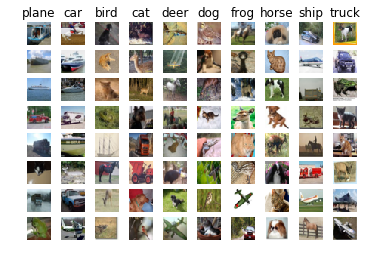

In [11]:
# An important way to gain intuition about how an algorithm works is to
# visualize the mistakes that it makes. In this visualization, we show examples
# of images that are misclassified by our current system. The first column
# shows images that our system labeled as "plane" but whose true label is
# something other than "plane".

examples_per_class = 8
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for cls, cls_name in enumerate(classes):
    idxs = np.where((y_test != cls) & (y_test_pred == cls))[0]
    idxs = np.random.choice(idxs, examples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(classes), i * len(classes) + cls + 1)
        plt.imshow(X_test[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name)
plt.show()

### Inline question 1:
Describe the misclassification results that you see. Do they make sense?

They kind of make sense. For example, misclassificatoins in plane category were most probably becuase there is lot of sky and bluish tinge in those images. Similary, in car category, it put some ships and trucks, which look a lot like a car in some angles. So,yes. It does make sense. 

## Neural Network on image features
Earlier in this assigment we saw that training a two-layer neural network on raw pixels achieved better classification performance than linear classifiers on raw pixels. In this notebook we have seen that linear classifiers on image features outperform linear classifiers on raw pixels. 

For completeness, we should also try training a neural network on image features. This approach should outperform all previous approaches: you should easily be able to achieve over 55% classification accuracy on the test set; our best model achieves about 60% classification accuracy.

In [12]:
# Preprocessing: Remove the bias dimension
# Make sure to run this cell only ONCE
print(X_train_feats.shape)
X_train_feats = X_train_feats[:, :-1]
X_val_feats = X_val_feats[:, :-1]
X_test_feats = X_test_feats[:, :-1]

print(X_train_feats.shape)

(49000, 155)
(49000, 154)


In [26]:
from cs682.classifiers.neural_net import TwoLayerNet

# input_dim = X_train_feats.shape[1]
# hidden_dim = 500
# num_classes = 10

# net = TwoLayerNet(input_dim, hidden_dim, num_classes)
# best_net = None

################################################################################
# TODO: Train a two-layer neural network on image features. You may want to    #
# cross-validate various parameters as in previous sections. Store your best   #
# model in the best_net variable.                                              #
################################################################################
best_net = None # store the best model into this
input_size = X_train_feats.shape[1]
learning_rates = [1e-1, 9e-1]
regularization_strengths = [1e-2, 1e-1]
hiddenSizes = range(500,501)
num_classes = 10
results = {}
best_val = -1
best_lr = -1
best_reg = -1
best_hidden_size = -1
inner_iterations = 3000
batch_size = 200
learning_rate_decay=0.95

num_iters = 10
for it in range(num_iters):
    for jt in range(num_iters):
        for kt in range(len(hiddenSizes)):
            learning_rate = learning_rates[0] + it * ((learning_rates[1] - learning_rates[0]) / num_iters)
            reg = regularization_strengths[0] + jt * ((regularization_strengths[1] - regularization_strengths[0])/ num_iters)
            hidden_size = hiddenSizes[kt]

            net = TwoLayerNet(input_size, hidden_size, num_classes)
            # Train the network
            stats = net.train(X_train_feats, y_train, X_val_feats, y_val,
                        learning_rate, learning_rate_decay,
                        reg, inner_iterations, batch_size,verbose=False)

            y_train_pred = net.predict(X_train_feats)
            y_val_pred = net.predict(X_val_feats)
            training_accuracy = np.mean(y_train == y_train_pred)
            validation_accuracy = np.mean(y_val == y_val_pred)
            results[(learning_rate, reg, hidden_size)] = (training_accuracy, validation_accuracy)
            print('lr %e reg %e hidden %f train accuracy: %f val accuracy: %f' % (
                        learning_rate, reg, hidden_size, training_accuracy, validation_accuracy))
            if validation_accuracy > best_val:
                best_val = validation_accuracy
                best_net = net
                best_lr = learning_rate
                best_reg = reg
                best_hidden_size = hidden_size

print('best validation accuracy achieved during cross-validation: lr %e reg %e hidden %f val accuracy: %f, ' % (learning_rate, reg, hidden_size, best_val))        


################################################################################
#                              END OF YOUR CODE                                #
################################################################################

lr 1.000000e-01 reg 1.000000e-02 hidden 500.000000 train accuracy: 0.523612 val accuracy: 0.517000
lr 1.000000e-01 reg 1.900000e-02 hidden 500.000000 train accuracy: 0.504714 val accuracy: 0.503000
lr 1.000000e-01 reg 2.800000e-02 hidden 500.000000 train accuracy: 0.491878 val accuracy: 0.489000
lr 1.000000e-01 reg 3.700000e-02 hidden 500.000000 train accuracy: 0.468082 val accuracy: 0.466000
lr 1.000000e-01 reg 4.600000e-02 hidden 500.000000 train accuracy: 0.451755 val accuracy: 0.454000
lr 1.000000e-01 reg 5.500000e-02 hidden 500.000000 train accuracy: 0.435306 val accuracy: 0.423000
lr 1.000000e-01 reg 6.400000e-02 hidden 500.000000 train accuracy: 0.416347 val accuracy: 0.410000
lr 1.000000e-01 reg 7.300000e-02 hidden 500.000000 train accuracy: 0.389245 val accuracy: 0.390000
lr 1.000000e-01 reg 8.200000e-02 hidden 500.000000 train accuracy: 0.364878 val accuracy: 0.370000
lr 1.000000e-01 reg 9.100000e-02 hidden 500.000000 train accuracy: 0.346286 val accuracy: 0.346000
lr 1.80000

lr 7.400000e-01 reg 3.700000e-02 hidden 500.000000 train accuracy: 0.443571 val accuracy: 0.409000
lr 7.400000e-01 reg 4.600000e-02 hidden 500.000000 train accuracy: 0.426714 val accuracy: 0.436000
lr 7.400000e-01 reg 5.500000e-02 hidden 500.000000 train accuracy: 0.383694 val accuracy: 0.386000
lr 7.400000e-01 reg 6.400000e-02 hidden 500.000000 train accuracy: 0.386776 val accuracy: 0.390000
lr 7.400000e-01 reg 7.300000e-02 hidden 500.000000 train accuracy: 0.368551 val accuracy: 0.353000
lr 7.400000e-01 reg 8.200000e-02 hidden 500.000000 train accuracy: 0.325898 val accuracy: 0.307000
lr 7.400000e-01 reg 9.100000e-02 hidden 500.000000 train accuracy: 0.305388 val accuracy: 0.307000
lr 8.200000e-01 reg 1.000000e-02 hidden 500.000000 train accuracy: 0.518673 val accuracy: 0.500000
lr 8.200000e-01 reg 1.900000e-02 hidden 500.000000 train accuracy: 0.473633 val accuracy: 0.489000
lr 8.200000e-01 reg 2.800000e-02 hidden 500.000000 train accuracy: 0.459327 val accuracy: 0.448000
lr 8.20000

In [27]:
# Run your best neural net classifier on the test set. You should be able
# to get more than 55% accuracy.

test_acc = (best_net.predict(X_test_feats) == y_test).mean()
print(test_acc)

0.514
